In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

## Explicit Method

In [15]:
L = 3
t_max = 5

dx = .05
dt = .001

Nx = int(L/dx) + 1
Nt = int(t_max/dt)

x_grid = np.linspace(0,L,Nx)
t_grid = np.linspace(0,t_max,Nt)

U = []

u_t_x_0 = []

for x in x_grid:
    u_t_x_0.append(x*(x-1)*(x-3))
U.append(u_t_x_0)

In [16]:
pd.DataFrame(U)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0,0.140125,0.261,0.363375,0.448,0.515625,0.567,0.602875,0.624,0.631125,...,-1.778625,-1.664,-1.530375,-1.377,-1.203125,-1.008,-0.790875,-0.551,-0.287625,0.0


In [17]:
for i in range(Nt):
    u_t_x = []
    
    u_line = U[-1]
    
    for j in range(1,Nx-1):
        # Equation 5.14 (slightly modified) to calculate u at each x value:
        u = -u_line[j] * (dt/(2*dx)) * (u_line[j+1] - u_line[j-1]) + u_line[j]
        # Append this value to the time step line
        u_t_x.append(u)

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,0)
    u_t_x.insert(len(u_line),0)

    # Now append the full solutions matrix
    U.append(u_t_x) 

In [18]:
pd.DataFrame(U)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0,0.140125,0.261000,0.363375,0.448000,0.515625,0.567000,0.602875,0.624000,0.631125,...,-1.778625,-1.664000,-1.530375,-1.377000,-1.203125,-1.008000,-0.790875,-0.551000,-0.287625,0.0
1,0.0,0.139759,0.260417,0.362695,0.447318,0.515011,0.566505,0.602531,0.623824,0.631119,...,-1.774872,-1.659869,-1.525983,-1.372494,-1.198685,-1.003845,-0.787261,-0.548227,-0.286040,0.0
2,0.0,0.139395,0.259837,0.362018,0.446637,0.514398,0.566009,0.602186,0.623645,0.631110,...,-1.771112,-1.655738,-1.521598,-1.368002,-1.194267,-0.999714,-0.783674,-0.545479,-0.284472,0.0
3,0.0,0.139033,0.259258,0.361341,0.445956,0.513784,0.565513,0.601839,0.623465,0.631100,...,-1.767345,-1.651607,-1.517219,-1.363524,-1.189868,-0.995610,-0.780114,-0.542756,-0.282920,0.0
4,0.0,0.138673,0.258682,0.360667,0.445276,0.513169,0.565015,0.601490,0.623283,0.631087,...,-1.763572,-1.647475,-1.512848,-1.359060,-1.185491,-0.991530,-0.776581,-0.540058,-0.281385,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0.0,0.009523,0.016826,0.039683,0.011373,0.139043,0.001491,0.299358,0.000159,0.500303,...,-0.358983,-0.003119,-0.197374,-0.015490,-0.076141,-0.031374,-0.030520,-0.019189,-0.009687,0.0
4997,0.0,0.009521,0.016821,0.039686,0.011361,0.139057,0.001489,0.299362,0.000159,0.500303,...,-0.358992,-0.003114,-0.197398,-0.015471,-0.076154,-0.031360,-0.030516,-0.019185,-0.009685,0.0
4998,0.0,0.009520,0.016816,0.039688,0.011350,0.139070,0.001487,0.299366,0.000158,0.500304,...,-0.359001,-0.003109,-0.197423,-0.015452,-0.076166,-0.031345,-0.030512,-0.019181,-0.009683,0.0
4999,0.0,0.009518,0.016810,0.039690,0.011339,0.139084,0.001484,0.299370,0.000158,0.500305,...,-0.359010,-0.003104,-0.197447,-0.015434,-0.076178,-0.031331,-0.030508,-0.019177,-0.009681,0.0


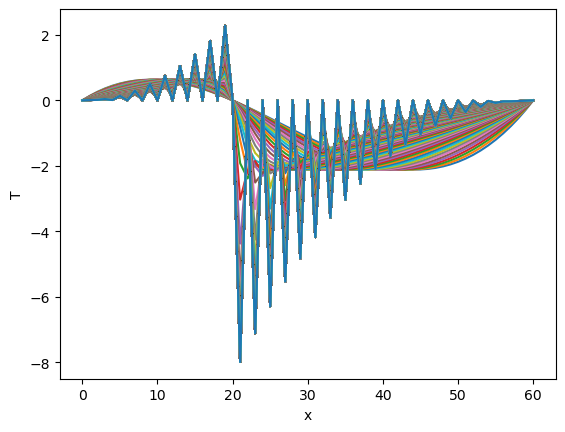

In [19]:
# Plotting t = 0 to t = 1000, in 20dt increments
for i in np.arange(0,len(U),20):
    plt.plot(U[i])
    plt.xlabel('x')
    plt.ylabel('T')
plt.show()

In [20]:
def heat_plotter(U, steps):

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('x')  # Set x-axis label
    ax.set_ylabel('T')  # Set y-axis label

    # Set the y-axis limits
    y_min = min([min(u) for u in U]) - 0.5  # Find the minimum y-value in U with some buffer
    y_max = max([max(u) for u in U]) + 0.5  # Find the maximum y-value in U with some buffer
    ax.set_ylim(y_min, y_max)

    lines = []  # List to store line objects
    alpha_decay = .5  # Factor to reduce the alpha of previous lines

    plt.show()

    for i in np.arange(0, len(U), len(U)//steps):
        # Update the alpha values of existing lines
        for line in lines:
            line.set_alpha(line.get_alpha() * alpha_decay)

        # Add new line
        new_line, = ax.plot(U[i], color='red', alpha=1.0)  # Start with full opacity
        lines.append(new_line)  # Store the new line object
        ax.set_title(f"Plot at time = {i/(len(U)-1)}s")  # Update the title with the current step

        # Handling plot display
        clear_output(wait=True)  # Clear the previous plot
        display(fig)  # Display the current figure

        time.sleep(0.25)  # Pause for half a second before the next update

In [22]:
len(U)

5001

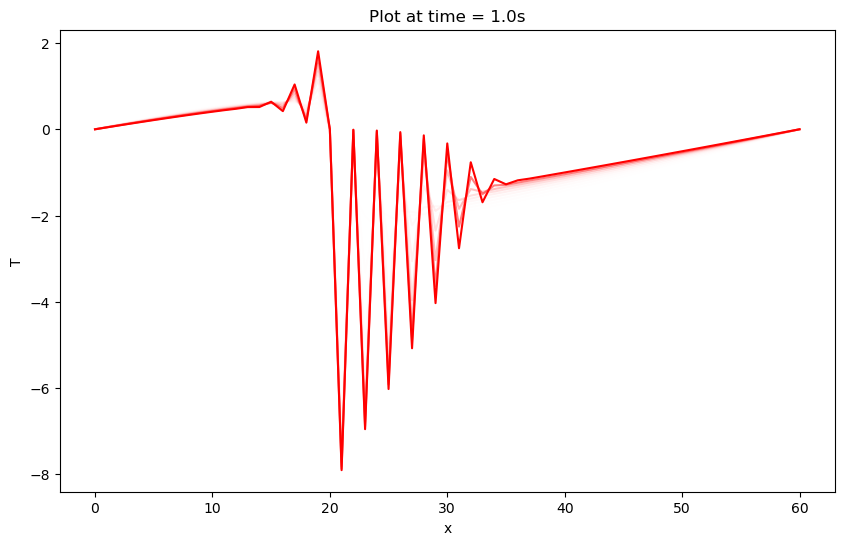

In [35]:
i_min = 0
i_max = 801
steps = 20

U_short = U[i_min:i_max]
heat_plotter(U_short, steps)

In [6]:
# Boundary Condition Functions (Direchelet - time domain)

def u_t_0(t):
    '''
    Assigns the initial value for the 0-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float]    
    '''
    return 0

def u_t_L(t):
    '''
    Assigns the initial value for the L-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return 0

# Initial Condition Functions

def u_0_x(x):
    '''
    Assigns the initial values for u (non-boundary points).
    If the initial value is a constant, leave function as-is.
    If the initial value is a function of x, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return x * (x - 1) * (x - 3)

In [7]:
# Assign length
L = 3
t_max = 5

# Grid spacing
dx = .1
dt = .1 # !-Note: For explicit needs to be less than dt**2/(2*D), implicit has no such restrictions for stability

# Number of dx nodes, including 0 node
Nx = int(L/dx) + 1

# Discretize x and t
x = np.arange(0,L+dx,dx)
t = np.arange(0,t_max+dt,dt)

# Create return array (n x m matrix)
n = len(x)
m = len(t)
T = np.zeros((m,n))

# Set boundary values
T[:,0] = u_t_0(0)
T[:,-1] = u_t_L(0)

# Derive the Lambda, as lambo
lambo = dt/(2*dx)

In [8]:
# LHS = A: a tridiagnonal matrix
A = np.diag([1+2*lambo]*(Nx-2)) + np.diag([-lambo]*(Nx-3),1) + np.diag([-lambo]*(Nx-3),-1)

## Crank-Nicholson

/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_1598/2640533299.py:24: RuntimeWarning: overflow encountered in scalar multiply
  term_new = 0.5 * unew[i] * (unew[i+1] - unew[i-1])
/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_1598/2640533299.py:23: RuntimeWarning: overflow encountered in scalar multiply
  term_n = 0.5 * un[i] * (un[i+1] - un[i-1])
/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_1598/2640533299.py:24: RuntimeWarning: invalid value encountered in scalar subtract
  term_new = 0.5 * unew[i] * (unew[i+1] - unew[i-1])
/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_1598/2640533299.py:23: RuntimeWarning: invalid value encountered in scalar subtract
  term_n = 0.5 * un[i] * (un[i+1] - un[i-1])


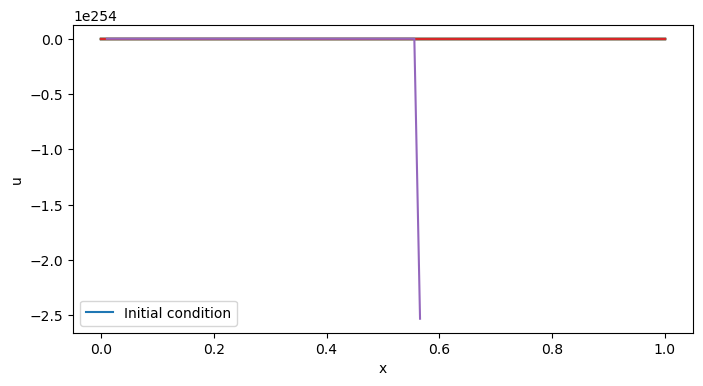

In [37]:
# Parameters
L = 1          # Length of the domain
N = 100           # Number of spatial points
dx = L / N        # Spatial step size
dt = 0.01         # Time step size
T = 2.0           # Total time
timesteps = int(T / dt)

# Initial condition: a sine wave
x = np.linspace(0, L, N)
u = np.sin(2 * np.pi * x / L)

# Plotting the results
plt.figure(figsize=(8, 4))
plt.plot(x, u, label='Initial condition')

def burgers_crank_nicolson(u):
    unew = np.copy(u)
    for n in range(timesteps):
        un = np.copy(unew)
        for i in range(1, N-1):
            # Nonlinear terms using averages
            term_n = 0.5 * un[i] * (un[i+1] - un[i-1])
            term_new = 0.5 * unew[i] * (unew[i+1] - unew[i-1])
            # Crank-Nicolson scheme
            unew[i] = un[i] - 0.5 * dt / dx * (term_n + term_new)
        # Periodic boundary conditions
        unew[0] = unew[-2]
        unew[-1] = unew[1]
        plt.plot(x, unew)
    return unew

# Run the simulation
u_final = burgers_crank_nicolson(u)

plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()